### **Imports**

In [73]:
import os
import cv2
from tqdm import tqdm
import shutil

import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import wasserstein_distance
from sklearn.cluster import KMeans
import seaborn as sns

## **Data Preprocessing**

Cropping function

In [74]:
def find_images(directory, extensions=['.jpg', '.jpeg', '.png']):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                # Get the full path to the file
                file_path = os.path.join(root, file)
                # Skip images in the 'road_view' folder
                if "road_view" in file_path:
                    continue
                image_files.append(file_path)
    return image_files


def crop_rectangle(image, x, y, width, height):
    """
    Crop a rectangle out of an image.

    Parameters:
    - image: Input image
    - x, y: Top-left corner coordinates of the rectangle
    - width, height: Width and height of the rectangle

    Returns:
    - Cropped region of the image
    """
    return image[y:y+height, x:x+width]

def crop_images(input_path, dest_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Define the rectangle
    x, y, width, height = 26, 200, 768, 1024

    image_paths = find_images(input_path)

    for image_path in tqdm(image_paths, desc="Processing images"):
        # Determine the corresponding path in the destination folder
        relative_path = os.path.relpath(image_path, input_path)
        dest_path = os.path.join(dest_folder, relative_path)

        # Create the subdirectories in the destination folder if needed
        dest_subfolder = os.path.dirname(dest_path)
        if not os.path.exists(dest_subfolder):
            os.makedirs(dest_subfolder)
        
        # Skip images in the 'road_view' folder
        if "road_view" in relative_path:
            shutil.copy(image_path, dest_path)  # Copy the image directly without cropping
            continue

        # Your image processing code with cv2
        image = cv2.imread(image_path)

        # Crop the rectangle
        cropped_region = crop_rectangle(image, x, y, width, height)

        # Save the cropped image to the destination folder
        cv2.imwrite(dest_path, cropped_region)

    print(f"Images cropped and saved to: {dest_folder}")



In [75]:
input_path = '/home/anto/University/Driving-Visual-Attention/data/images'
dest_folder = '/home/anto/University/Driving-Visual-Attention/data/cropped_images'

do_cropping = False
if do_cropping:
    crop_images(input_path, dest_folder)

## **Data Analysis**

Extract 20 random images, one for each driver and perform a color distribution analysis.

In [76]:
# Extract 20 random paths, one for each driver
def extract_drivers_photos(main_folder, display = False):
    # List of dictionaries to store paths
    paths = []

    # Loop through the main path
    for driver in os.listdir(main_folder):

        if driver!= 'road_view':

            driver_folder_path = os.path.join(main_folder, driver)

            # Get a list of subfolders inside the driver folder
            subfolders = [sf for sf in os.listdir(driver_folder_path)]

            random_subfolder = random.choice(subfolders)

            # Get the path to a random image in the selected subfolder
            image_files = [f for f in os.listdir(os.path.join(driver_folder_path, random_subfolder))]

            random_image = random.choice(image_files)

            image_path = os.path.join(driver_folder_path, random_subfolder, random_image)

            # Store the driver's name and image path in a dictionary
            driver_dict = {'driver_num': driver, 'img_path': image_path}
            print(driver_dict['driver_num'], driver_dict['img_path'])
            paths.append(driver_dict)
  
    return paths

drivers_paths = extract_drivers_photos('/home/anto/University/Driving-Visual-Attention/data/cropped_images', display=True)

driver20 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver20/sample101/frame_0010.jpg
driver22 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver22/sample24/frame_0040.jpg
driver21 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver21/sample45/frame_0070.jpg
driver3 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver3/sample106/frame_0130.jpg
driver13 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver13/sample85/frame_0200.jpg
driver23 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver23/sample98/frame_0150.jpg
driver5 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver5/sample74/frame_0060.jpg
driver8 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver8/sample41/frame_0040.jpg
driver15 /home/anto/University/Driving-Visual-Attention/data/cropped_images/driver15/sample93/frame_0000.jpg
driver18 /home/anto/Uni

Calculate the histograms of one image. Using 2 different approaches:
- Compute 3 different histograms, one for Red, Green, Blue channel.
- Transform into HSV and compute a 2D histogram using only Hue and Saturation channels:
  - **Hue:** Represents the type of color, often described as the dominant wavelength of light. It is measured in degrees on a color wheel, with values ranging from 0 to 359. The 0 and 360 degrees correspond to red, while the other hues are distributed around the color wheel.
    - Red has a hue value around 0 or 360 degrees.
    - Green has a hue value around 120 degrees.
    - Blue has a hue value around 240 degrees.
  - **Saturation:** Refers to the intensity or vividness of a color. It quantifies the amount of white light mixed with a pure hue. A saturation value of 0 represents a shade of gray, and a value of 1 (or 100%) represents a fully saturated color.


In [77]:
def RGB_histograms(image_path,choose_dim, display = False, normalize = True):
    ### ABOUT NORMALIZATION:
    ### cv2.NORM_L1 if you want a probability distribution (sum of all = 1) alpha = 1
    ### NORM_MINMAX if you want them to be scaled in the range [0,1] alpha=0, beta=1

    # Check if the expected_dim is a valid string
    if choose_dim not in ["1D","2D", "3D"]:
        raise ValueError("Expected dimension must be '1D' or '2D' or '3D")
    # Read the image
    image = cv2.imread(image_path)

    #Convert from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if choose_dim=='1D':
        # Split the image into RGB channels
        channels = cv2.split(image_rgb)

        # Calculate histograms for each channel
        hist_red = cv2.calcHist([channels[0]], [0], None, [16], [0, 256])
        hist_green = cv2.calcHist([channels[1]], [0], None, [16], [0, 256])
        hist_blue = cv2.calcHist([channels[2]], [0], None, [16], [0, 256])
        
        # Normalize the histograms
        if normalize:
            hist_red = cv2.normalize(hist_red,None, alpha=1,norm_type=cv2.NORM_L1)
            hist_green = cv2.normalize(hist_green,None, alpha=1, norm_type=cv2.NORM_L1)
            hist_blue = cv2.normalize(hist_blue,None, alpha=1, norm_type=cv2.NORM_L1)
    
    if choose_dim=='3D':
        hist_3D = cv2.calcHist([image_rgb], [0, 1, 2], None, [4, 4, 4], [0, 256, 0, 256, 0, 256])
        if normalize:
            hist_3D = cv2.normalize(hist_3D,None, alpha=1, norm_type=cv2.NORM_L1)
        hist_3D = hist_3D.flatten()   

    # Plot the 3 histograms
    if display:
        # Image subplot
        plt.figure(figsize=(15, 3))
        plt.imshow(image_rgb), plt.title('Image')
        if choose_dim=='3D':
            plt.figure(figsize=(10, 5))
            plt.plot(hist_3D)
            plt.title('Flattened 3D RGB Histogram')
            plt.xlabel('Bin')
            plt.ylabel('Normalized Frequency')
        if choose_dim=='1D': 
            plt.figure(figsize=(15, 8))
            # RGB histograms
            plt.subplot(231), plt.plot(hist_red, color='red'), plt.title('Red Channel Histogram')
            plt.subplot(232), plt.plot(hist_green, color='green'), plt.title('Green Channel Histogram')
            plt.subplot(233), plt.plot(hist_blue, color='blue'), plt.title('Blue Channel Histogram') 

    if choose_dim =='3D':
        return hist_3D
    if choose_dim =='1D':
        return hist_red, hist_green, hist_blue


def HSV_histogram(image_path, choose_dim, normalize = True,  display = False):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Check if the expected_dim is a valid string
    if choose_dim not in ["1D", "2D", "3D"]:
        raise ValueError("Expected dimension must be '1D' or '2D' or '3D")

    ## Parameters
    h_bins = 64
    s_bins = 64
    v_bins = 64
    # hue varies from 0 to 179, saturation from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    v_ranges = [0, 256]

    if choose_dim == '3D':
        channels=[0,1,2]
        histSize = [4, 4, 4]
        ranges = h_ranges + s_ranges + v_ranges# concat lists

        # Calculate a 3D histogram for Hue and Saturation and Value 
        hist_3d = cv2.calcHist([hsv_image], channels,  None, histSize, ranges, accumulate=False)

        # Normalize the histogram
        if normalize:
            hist_3d = cv2.normalize(hist_3d,None, alpha=1, norm_type=cv2.NORM_L1)

        #Flatten otherwise impossible to visualize and use
        hist_3d = hist_3d.flatten()


    if choose_dim == '2D':
        histSize = [8, 16]
        ranges = h_ranges + s_ranges # concat lists
        # Use the 0-th and 1-st channels (just Hue and Saturation)
        channels = [0, 1]
        # Calculate a 2D histogram for Hue and Saturation
        hist_2d = cv2.calcHist([hsv_image], channels,  None, histSize, ranges, accumulate=False)

        # Normalize the histogram
        if normalize:
            hist_2d = cv2.normalize(hist_2d,None, alpha=1, norm_type=cv2.NORM_L1)
    
    if choose_dim == '1D':
        # Split the HSV image into individual channels
        h_channel, s_channel, v_channel = cv2.split(hsv_image)

        # Calculate histograms for each channel
        h_hist = cv2.calcHist([h_channel], [0], None, [h_bins], h_ranges)
        s_hist = cv2.calcHist([s_channel], [0], None, [s_bins], s_ranges)
        v_hist = cv2.calcHist([v_channel], [0], None, [v_bins], v_ranges)
        if normalize:
            h_hist = cv2.normalize(h_hist,None, alpha=1, norm_type=cv2.NORM_L1)
            s_hist = cv2.normalize(s_hist,None, alpha=1, norm_type=cv2.NORM_L1)
            v_hist = cv2.normalize(v_hist, None, alpha=1, norm_type=cv2.NORM_L1)



    if display:
        # Display original image, HSV image, and 2D histogram side by side
        plt.figure(figsize=(15, 3))
        # Original image subplot
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        # HSV image subplot
        plt.subplot(122)
        plt.imshow(hsv_image)
        plt.title('HSV Image')
        plt.axis('off')
        if choose_dim == '2D':
            plt.figure(figsize=(10, 5))
            # 2D histogram subplot
            plt.imshow(hist_2d, interpolation='nearest', cmap='viridis')
            plt.title('2D Histogram')
            plt.xlabel('Hue')
            plt.ylabel('Saturation')
            plt.colorbar()
        
        if choose_dim == '1D':
            # Plot the histograms
            plt.figure(figsize=(15, 8))
            plt.subplot(231)
            plt.plot(h_hist, color='blue')
            plt.title('Hue Histogram')
            plt.subplot(232)
            plt.plot(s_hist, color='grey')
            plt.title('Saturation Histogram')
            plt.subplot(233)
            plt.plot(v_hist, color='black')
            plt.title('Value Histogram')
        if choose_dim == '3D':
            plt.figure(figsize=(10, 5))
            plt.plot(hist_3d)
            plt.title('Flattened 3D HSV Histogram')
            plt.xlabel('Bin')
            plt.ylabel('Normalized Frequency')
        

    if choose_dim == '2D':
        return hist_2d.flatten()
    if choose_dim == '3D':
        return hist_3d
    if choose_dim == '1D':
        return h_hist, s_hist, v_hist

Compute the color distribution aka find the colors in an image and plot the distribution.

In [78]:
def encode_hex(color):
    b, g, r = color
    hex_value = '#{0:02x}{1:02x}{2:02x}'.format(r, g, b)
    #print(hex_value)
    return hex_value

def color_distribution(image_path, number_of_colors=16, display = True):
    # Read image into range 0 to 1
    img = cv2.imread(image_path) / 255

    # Quantize to specified number of colors using k-means
    h, w, c = img.shape
    img2 = img.reshape(h * w, c)
    kmeans_cluster = KMeans(n_clusters=number_of_colors,n_init=10)
    kmeans_cluster.fit(img2)
    cluster_centers = kmeans_cluster.cluster_centers_
    cluster_labels = kmeans_cluster.labels_

    # Scale back to range 0-255 and reshape
    img3 = cluster_centers[cluster_labels].reshape(h, w, c) * 255.0
    img3 = img3.astype('uint8')

    # Reshape img to 1 column of 3 colors
    img4 = img3.reshape(-1, 3)

    # Get the unique colors
    colors, counts = np.unique(img4, return_counts=True, axis=0)
    unique = list(zip(colors, counts))

    if display:
        # Plot each color
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        for i, (color, count) in enumerate(unique):
            ax2.bar(i, count, color=encode_hex(color))
        ax2.set_title('Color Distribution')
        # Display the processed image
        ax1.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        ax1.set_title('Image with Clustered Colors')

    return unique

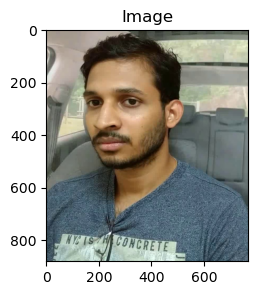

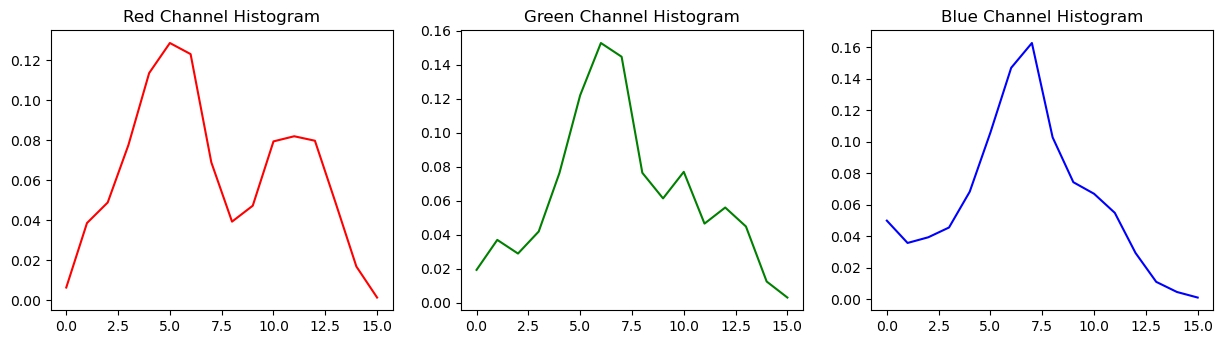

In [79]:
random_image_path = '/home/anto/University/Driving-Visual-Attention/data/cropped_images/driver20/sample108/frame_0000.jpg'
r,g,b = RGB_histograms(random_image_path,choose_dim='1D',display = True)

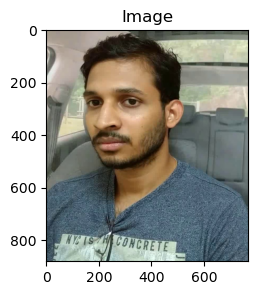

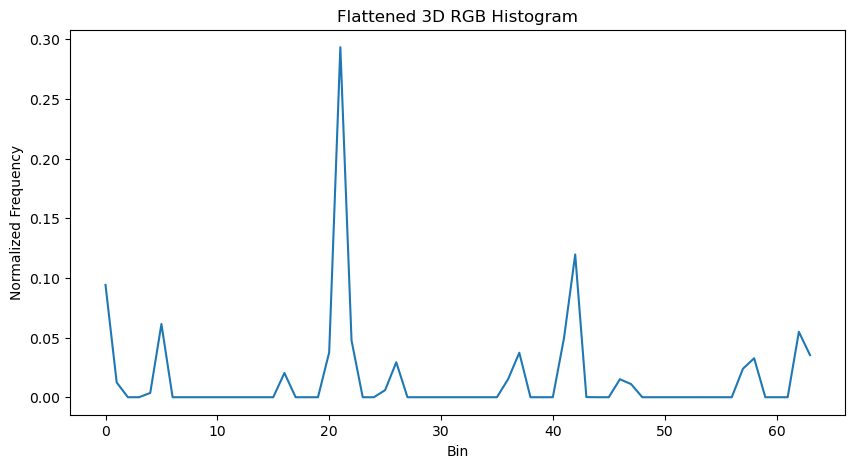

In [80]:
hist_3D = RGB_histograms(random_image_path,choose_dim='3D',display = True)

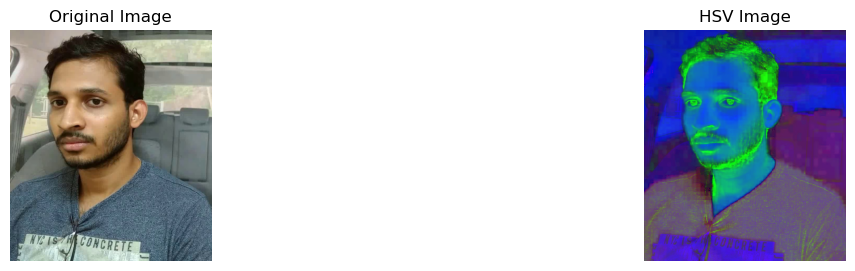

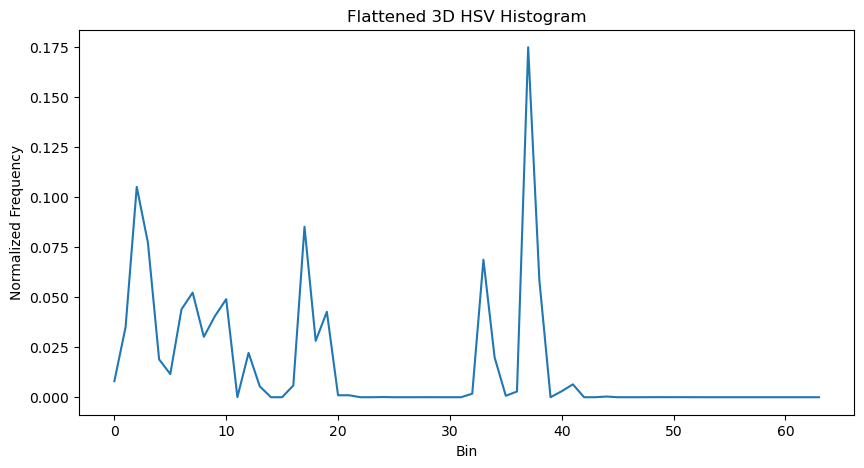

In [81]:
hsv_hist_2D = HSV_histogram(random_image_path,choose_dim='3D',display = True)

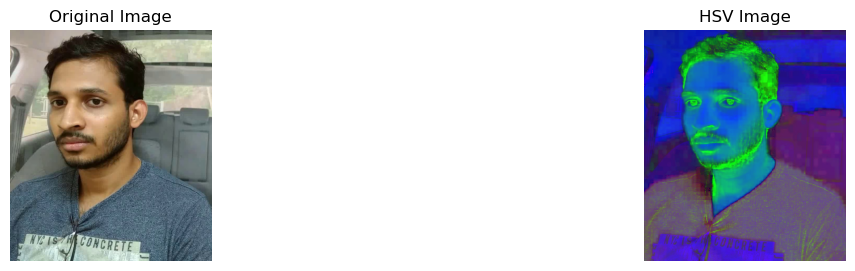

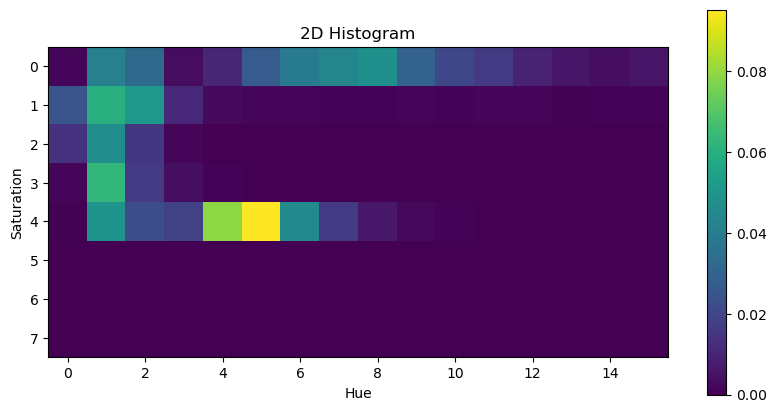

In [82]:
hist_2d = HSV_histogram(random_image_path,choose_dim='2D',display = True)

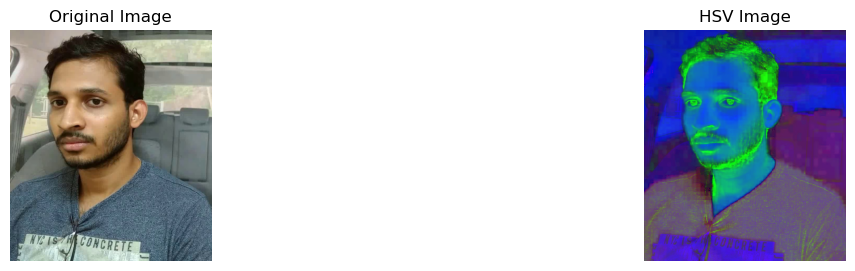

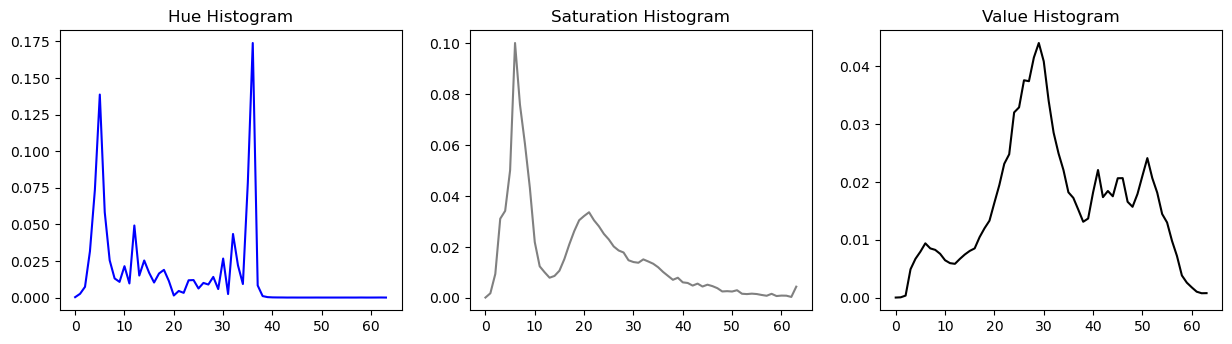

In [83]:
h_hist, s_hist, v_hist = HSV_histogram(random_image_path,choose_dim='1D',display = True)

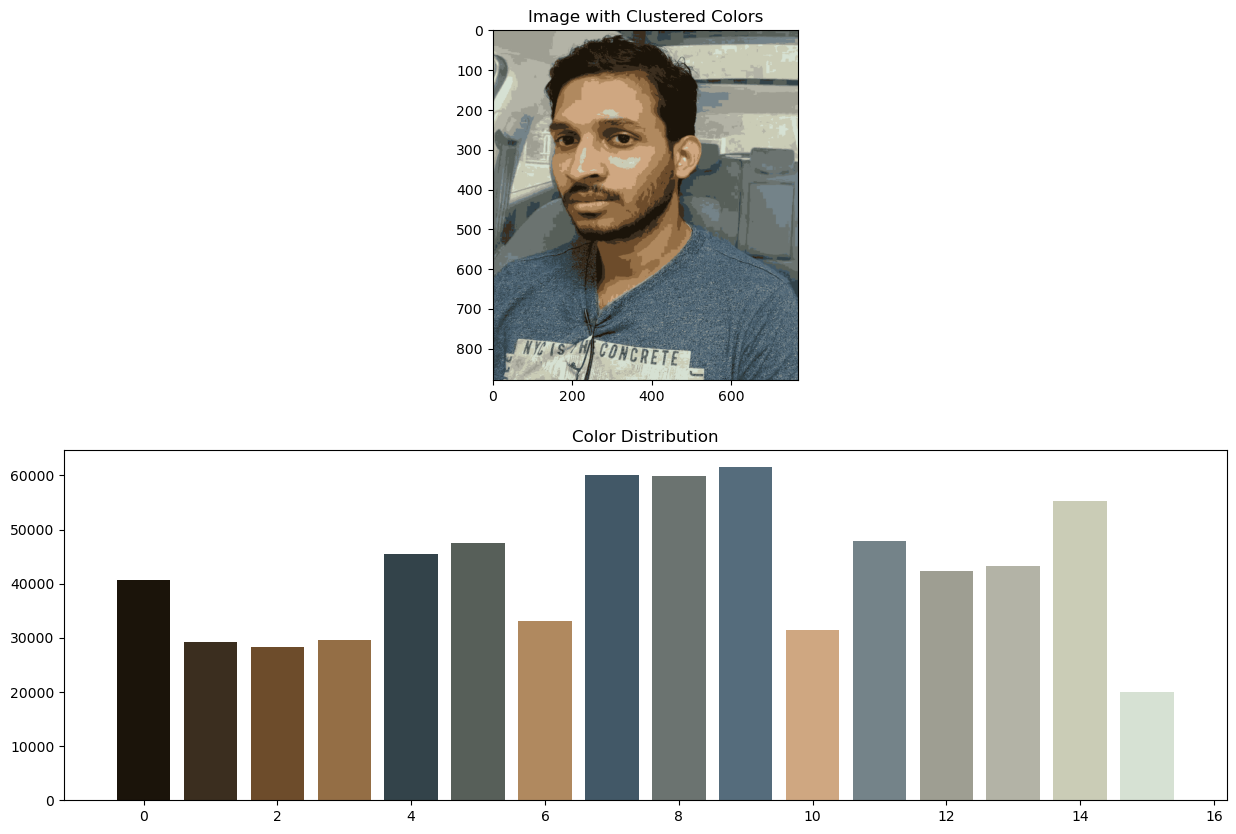

In [84]:
color_dist = color_distribution(random_image_path, display = True)

Calculate the histograms for all 20 images and compare the distance metrics.
We write different functions that calculate the different metrics of 2 histograms.

In [85]:
def retrieve_2_histograms(image_path1, image_path2, dimension, hist_type):
    if dimension not in ["1D", "2D", "3D"]:
        raise ValueError("Expected dimension must be '1D' or '2D' or '3D")

    if hist_type == 'RGB':
        if dimension == '1D':
            r1, g1, b1 = RGB_histograms(image_path1, choose_dim=dimension)
            r2, g2, b2 = RGB_histograms(image_path2, choose_dim=dimension)
            return [r1, g1, b1, r2, g2, b2]
        elif dimension == '3D':
            rgb_3d_1 = RGB_histograms(image_path1, choose_dim=dimension)
            rgb_3d_2 = RGB_histograms(image_path2, choose_dim=dimension)
            return [rgb_3d_1, rgb_3d_2]
    elif hist_type == 'HSV':
        if dimension == '1D':
            h1, s1, v1 = HSV_histogram(image_path1, choose_dim=dimension)
            h2, s2, v2 = HSV_histogram(image_path2, choose_dim=dimension)
            return [h1, s1, v1, h2, s2, v2]
        elif dimension == '2D':
            hs_1 = HSV_histogram(image_path1, choose_dim=dimension)
            hs_2 = HSV_histogram(image_path2, choose_dim=dimension)
            return [hs_1, hs_2]
        elif dimension == '3D':
            hsv_3d_1 = HSV_histogram(image_path1, choose_dim=dimension)
            hsv_3d_2 = HSV_histogram(image_path2, choose_dim=dimension)
            return [hsv_3d_1, hsv_3d_2]
    else:
        raise ValueError("Invalid histogram type")


In [86]:
def EMD(input,do_print = False):
    if len(input) == 6:
        histograms = {}
        distances = {}
        histograms['image_a'] = {'channel_1': input[0], 'channel_2': input[1], 'channel_3': input[2]}
        histograms['image_b'] = {'channel_1': input[3], 'channel_2': input[4], 'channel_3': input[5]}

        bins_1 = np.arange(len(input[0]))
        bins_2 = np.arange(len(input[1]))
        bins_3 = np.arange(len(input[2]))

        distances['channel_1'] = wasserstein_distance(bins_1,bins_1,histograms['image_a']['channel_1'], histograms['image_b']['channel_1'])
        distances['channel_2'] = wasserstein_distance(bins_2,bins_2,histograms['image_a']['channel_2'], histograms['image_b']['channel_2'])
        distances['channel_3'] = wasserstein_distance(bins_3,bins_3,histograms['image_a']['channel_3'], histograms['image_b']['channel_3'])
        distances['mean'] =  np.mean([distances['channel_1'], distances['channel_2'], distances['channel_3']])

        if do_print:
            print("Wasserstein Distances:", distances)
        return distances

    elif len(input) == 2:
        hist_img_a = input[0]
        hist_img_b = input[1]

        # Wassertein Distance, we need to specify the number of bins
        bins = np.arange(len(hist_img_a))
        wa_distance = wasserstein_distance(bins,bins,hist_img_a, hist_img_b)

        if do_print:
            print("Wasserstein Distance:", wa_distance)
        return wa_distance

    else:
        raise ValueError("Wrong number of histograms inserted")

def Chi_S(input,do_print = False):
    if len(input) == 6:
        histograms = {}
        distances = {}
        histograms['image_a'] = {'channel_1': input[0], 'channel_2': input[1], 'channel_3': input[2]}
        histograms['image_b'] = {'channel_1': input[3], 'channel_2': input[4], 'channel_3': input[5]}

        bins_1 = np.arange(len(input[0]))
        bins_2 = np.arange(len(input[1]))
        bins_3 = np.arange(len(input[2]))

        distances['channel_1'] = cv2.compareHist(histograms['image_a']['channel_1'], histograms['image_b']['channel_1'], cv2.HISTCMP_CHISQR)
        distances['channel_2'] = cv2.compareHist(histograms['image_a']['channel_2'], histograms['image_b']['channel_2'], cv2.HISTCMP_CHISQR)
        distances['channel_3'] = cv2.compareHist(histograms['image_a']['channel_3'], histograms['image_b']['channel_3'], cv2.HISTCMP_CHISQR)
        distances['mean'] = np.mean([distances['channel_1'], distances['channel_2'], distances['channel_3']])

        if do_print:
            print("Chi-Squared Distances:", distances)
        return distances

    elif len(input) == 2:
        hist_img_a = input[0]
        hist_img_b = input[1]

        # Chi-Squared Distance
        chi_squared_distance = cv2.compareHist(hist_img_a, hist_img_b, cv2.HISTCMP_CHISQR)
        if do_print:
            print("Chi-Squared Distance:", chi_squared_distance)
        return chi_squared_distance

    else:
        raise ValueError("Wrong number of histograms inserted")

def KL(input,do_print = False):
    if len(input) == 6:
        histograms = {}
        distances = {}
        histograms['image_a'] = {'channel_1': input[0], 'channel_2': input[1], 'channel_3': input[2]}
        histograms['image_b'] = {'channel_1': input[3], 'channel_2': input[4], 'channel_3': input[5]}

        bins_1 = np.arange(len(input[0]))
        bins_2 = np.arange(len(input[1]))
        bins_3 = np.arange(len(input[2]))

        distances['channel_1'] = cv2.compareHist(histograms['image_a']['channel_1'], histograms['image_b']['channel_1'], cv2.HISTCMP_KL_DIV)
        distances['channel_2'] = cv2.compareHist(histograms['image_a']['channel_2'], histograms['image_b']['channel_2'], cv2.HISTCMP_KL_DIV)
        distances['channel_3'] = cv2.compareHist(histograms['image_a']['channel_3'], histograms['image_b']['channel_3'], cv2.HISTCMP_KL_DIV)
        distances['mean'] = np.mean([distances['channel_1'], distances['channel_2'], distances['channel_3']])

        if do_print:
            print("Kullback-Leibler Divergences:", distances)
        return distances

    elif len(input) == 2:
        hist_img_a = input[0]
        hist_img_b = input[1]

        # Kullback-Leibler Divergence
        kl_divergence = cv2.compareHist(hist_img_a, hist_img_b, cv2.HISTCMP_KL_DIV)
        if do_print:
            print("Kullback-Leibler Divergence:", kl_divergence)
        return kl_divergence

    else:
        raise ValueError("Wrong number of histograms inserted")


In [87]:
output = retrieve_2_histograms(random_image_path,random_image_path,'1D','RGB')
distance = Chi_S(output,do_print=True)

Chi-Squared Distances: {'channel_1': 0.0, 'channel_2': 0.0, 'channel_3': 0.0, 'mean': 0.0}


In [88]:
def plot_matrix(matrix, title, figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(matrix, cmap='viridis', annot=True, fmt=".0f", xticklabels=False, yticklabels=False, annot_kws={"size": 10}, ax=ax)
    plt.title(title)
    plt.show()
    return


def compare_images(dict_image_paths, dimension, hist_type):
    num_images = len(dict_image_paths)
    # Create a matrix to store the comparison results
    earth_mover_matrix = np.zeros((num_images, num_images))
    chi_squared_matrix = np.zeros((num_images, num_images))
    kl_divergence_matrix = np.zeros((num_images, num_images))

    for i in range(num_images - 1):
        for j in range(i + 1, num_images):
            # Calculate histograms for the current pair of images
            output_histograms = retrieve_2_histograms(dict_image_paths[i]['img_path'],dict_image_paths[j]['img_path'], dimension=dimension, hist_type= hist_type)
            symmetric_histograms = retrieve_2_histograms(dict_image_paths[j]['img_path'],dict_image_paths[i]['img_path'], dimension=dimension, hist_type= hist_type)

            # Compare histograms using the three distance metrics
            earth_mover_distance = EMD(output_histograms)
            chi_squared_distance = Chi_S(output_histograms)
            kl_divergence = KL(output_histograms)
            # Compute the Symetrics
            chi_s_symm = Chi_S(symmetric_histograms)
            kl_symm = KL(symmetric_histograms)
            
            if dimension == '3D' or dimension == '2D':
                earth_mover_matrix[i, j] = earth_mover_distance
                chi_squared_matrix[i, j] = chi_squared_distance
                kl_divergence_matrix[i, j] = kl_divergence
                #KL  and Chi-Squared are not symmetric
                chi_squared_matrix[j, i] = chi_s_symm
                kl_divergence_matrix[j, i] = kl_symm

            elif dimension == '1D':
                earth_mover_matrix[i, j] = earth_mover_distance['mean']
                chi_squared_matrix[i, j] = chi_squared_distance['mean']
                kl_divergence_matrix[i, j] = kl_divergence['mean']
                #KL  and Chi-Squared are not symmetric
                chi_squared_matrix[j, i] = chi_s_symm['mean']
                kl_divergence_matrix[j, i] = kl_symm['mean']
            else:
                raise ValueError("Wrong number of dimensions")


    # Plot the matrices using seaborn
    plot_matrix(earth_mover_matrix, "Earth Mover's Distance Matrix")
    plot_matrix(chi_squared_matrix, "Chi-Squared Distance Matrix")
    plot_matrix(kl_divergence_matrix, "Kullback-Leibler Divergence Matrix")
    return


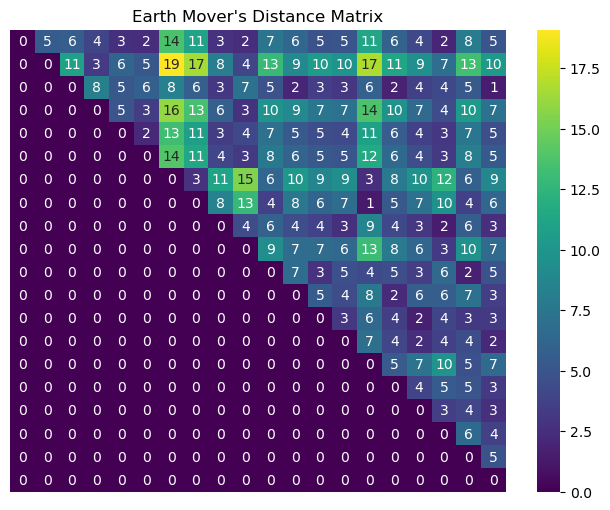

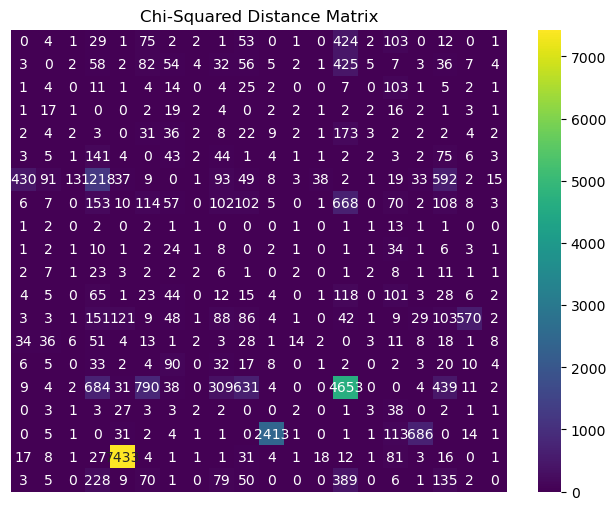

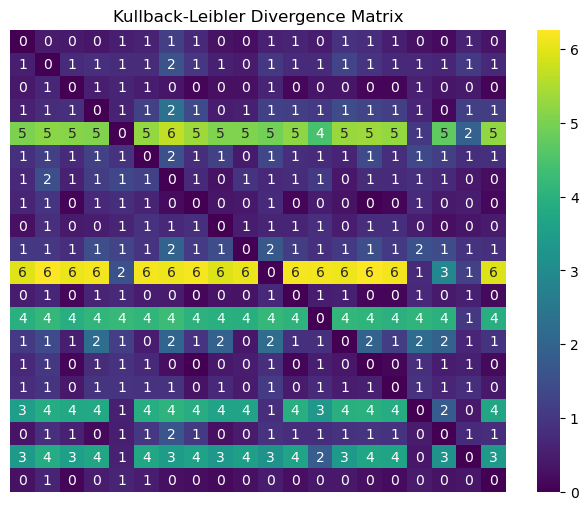

In [89]:
compare_images(drivers_paths,'3D','RGB')

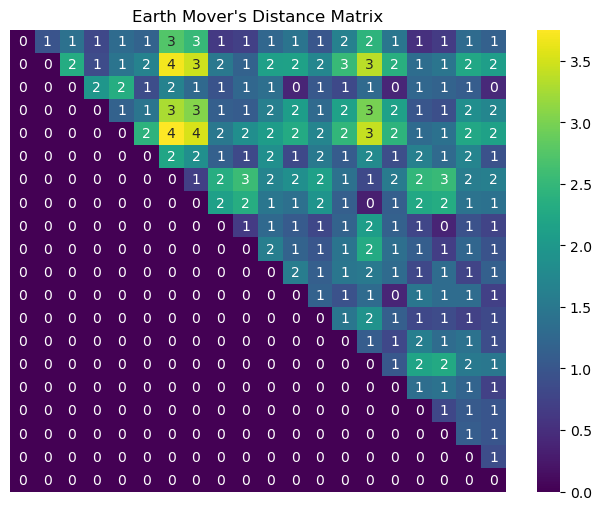

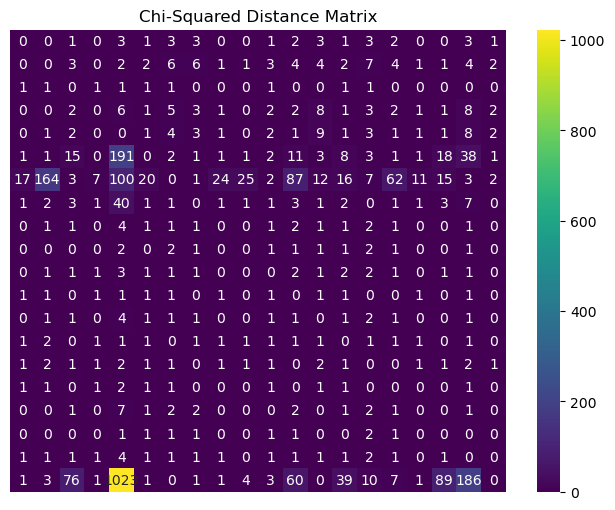

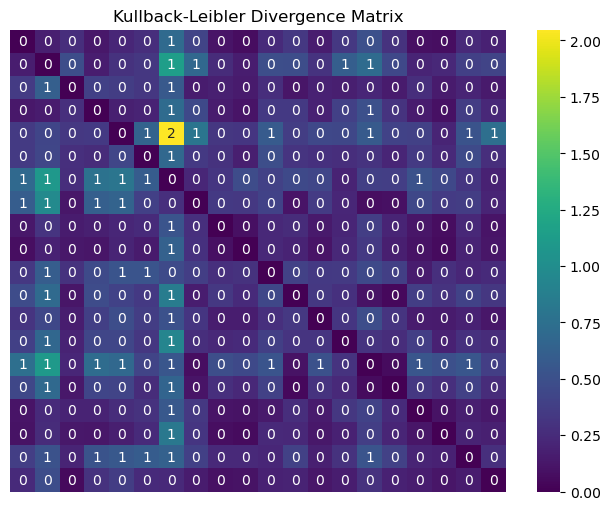

In [90]:
compare_images(drivers_paths,'1D','RGB')

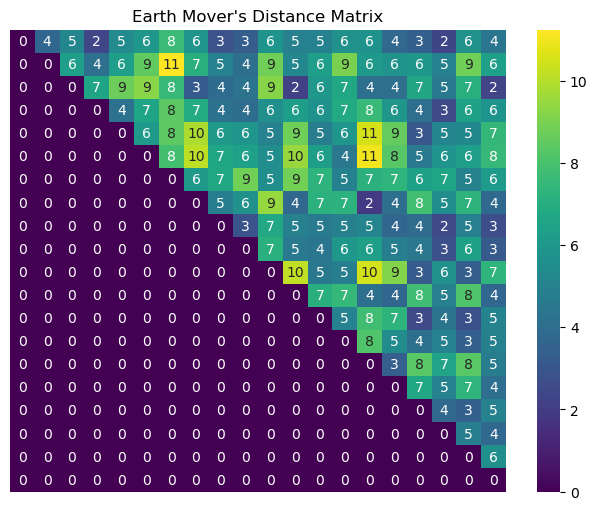

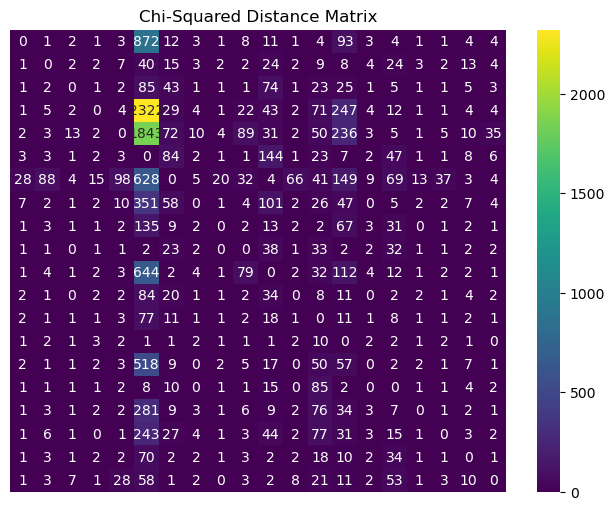

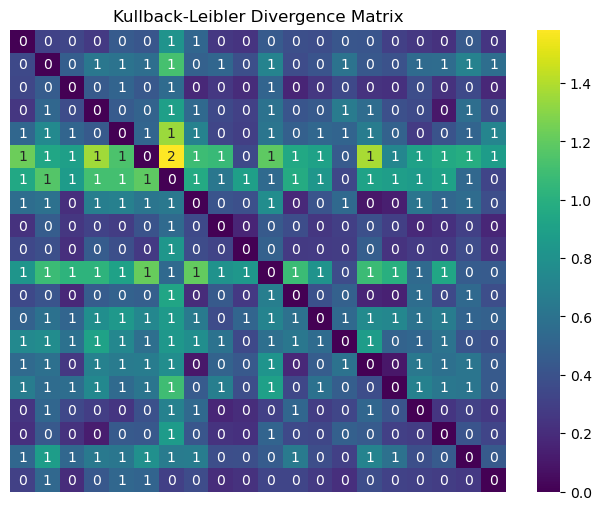

In [91]:
compare_images(drivers_paths,'1D','HSV')

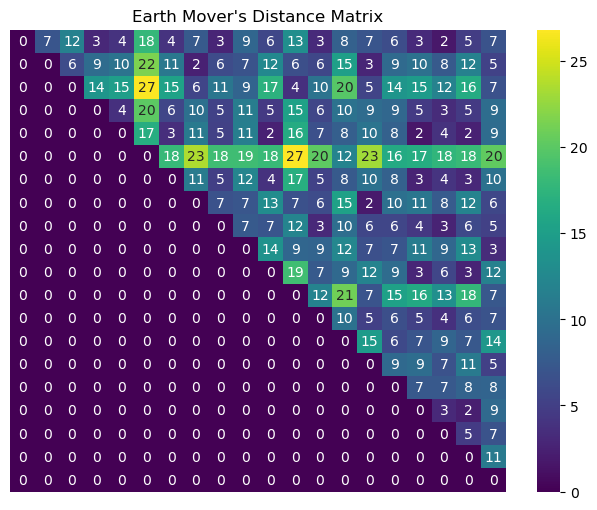

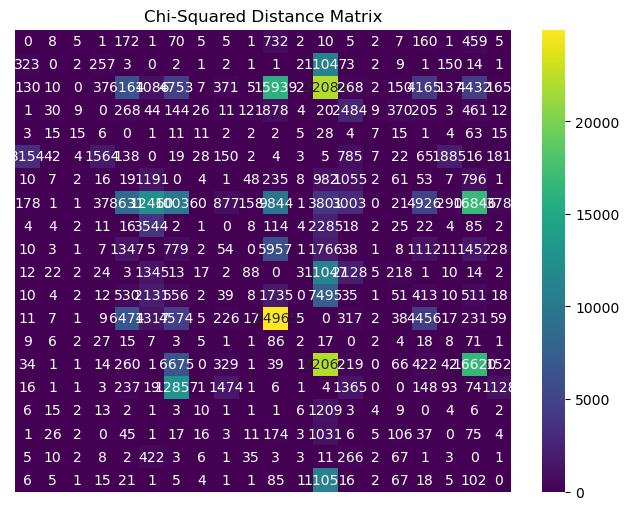

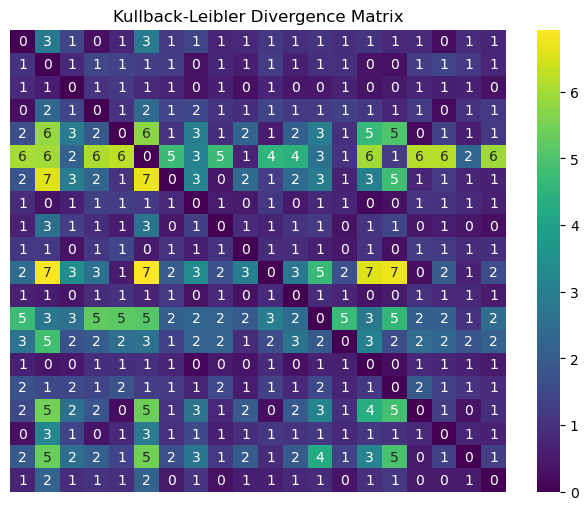

In [92]:
compare_images(drivers_paths,'2D','HSV')

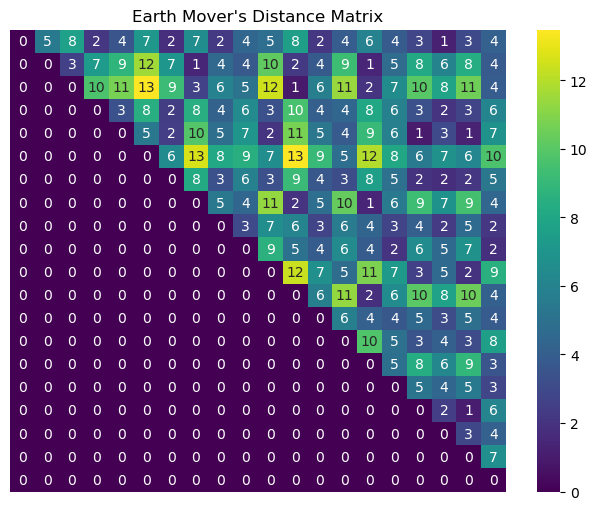

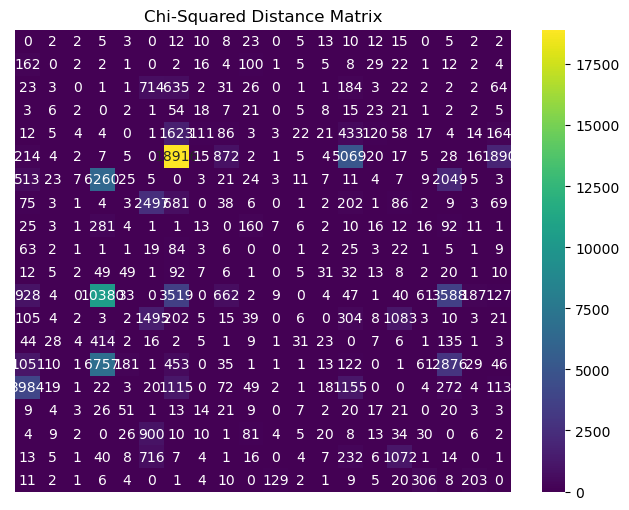

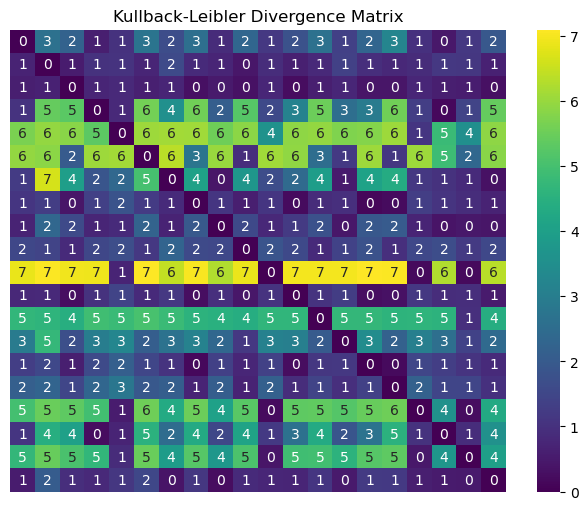

In [93]:
compare_images(drivers_paths,'3D','HSV')